This is an example script for the PhotoReceptor model. Please run each cell in sequence. 

Warnings about "replacing module" when exectuing the first cell can be ignored.

If you want to change how many iterations are run, you can do so in the second cell.
- nproposals: number of proposals evaluated in parallel in the Generalized Metropolis Hastings algorithm
- niterations: number of total iterations

The values given below (1000 proposals for 100 iterations) will take about 5 minutes to run on an 8-core machine.

Remember that you can remove output from the cells by selecting "Cell/All Output/Clear". And if the Kernel hangs for some reason, then you can choose "Kernel/Restart" from the menu.

In [ ]:
###You will need to run this cell only once, unless some workers crash and shut down
NPROCS = 16
if nprocs() < NPROCS
    addprocs(NPROCS-nprocs())
end
println("Number of parallel processes: ",nprocs())

###Load the GMHExamples package on all processes
@everywhere include("../../GMH-Examples.jl")

###Load the PyPlot package
using PyPlot
println("PyPlot package loaded successfully")

In [19]:
println("Number of parallel processes running: ",nprocs())

using GeneralizedMetropolisHastings
using GMHExamples

println("================================")
println("Initialize Simulation Parameters")
println("================================")

#Standard M-H for nproposals == 1
#Generalized M-H for nproposals > 1
nproposals = 10000

#MCMC iteration specifications
nburnin = 0
niterations = 100
ntunerperiod = 5

###Values of the model
numvilli1 = 30000

#specify the values that determine the priors on the parameters
latencylocation = (2.0,3.5) #uniform distribution with (low,high) values
latencyscale = (0.2,0.7) #uniform distribution with (low,high) values
refractorylocation = (4.0,6.0) #uniform distribution with (low,high) values
refractoryscale = (1.5,2.5) #uniform distribution with (low,high) values
bumpamplitude = (3.0,5.0) #uniform distribution with (low,high) values
bumpshape = (log(3.0),0.1) #lognormal distribution with (location,scale) 
bumpscale = (log(2.5),0.1) #lognormal distribution with (location,scale)

photons1 = photonsequence("../data/naturallight.jld")
current1 = lightinducedcurrent("../data/naturallight.jld")

modelpolicy1 = policy(:photoreceptor;bump = :sample) #7-parameter model with latency, refractory and bump parameters
params1 = parameters(:photoreceptor,modelpolicy1,latencylocation,latencyscale,refractorylocation,refractoryscale,
                                                bumpamplitude,bumpshape,bumpscale)

####Variance for the noise model, estimated from previous runs
variance1 = [3600.0]

println("==========================================")
println("Simulation parameters defined successfully")
println("==========================================")

Number of parallel processes running: 16
Initialize Simulation Parameters
Simulation parameters defined successfully


In [20]:
###Create a PhotoReceptor model
model1 = model(:photoreceptor,params1,photons1,current1,variance1,numvilli1,modelpolicy1)

###Show the model
println("==========================")
println("Model defined successfully")
println("==========================")
show(model1)

Model defined successfully
Model PhotoReceptorModel
parameters: Array{AbstractParameter} with
[1] ParameterUnivariate
 key: latencylocation
 prior: Distributions.Uniform(a=2.0, b=3.5)
 default: 2.75
[2] ParameterUnivariate
 key: latencyscale
 prior: Distributions.Uniform(a=0.2, b=0.7)
 default: 0.44999999999999996
[3] ParameterUnivariate
 key: refractorylocation
 prior: Distributions.Uniform(a=4.0, b=6.0)
 default: 5.0
[4] ParameterUnivariate
 key: refractoryscale
 prior: Distributions.Uniform(a=1.5, b=2.5)
 default: 2.0
[5] ParameterUnivariate
 key: bumpamplitude
 prior: Distributions.Uniform(a=3.0, b=5.0)
 default: 4.0
[6] ParameterUnivariate
 key: bumpshape
 prior: Distributions.LogNormal(μ=1.0986122886681096, σ=0.1)
 default: 3.015037562578202
[7] ParameterUnivariate
 key: bumpscale
 prior: Distributions.LogNormal(μ=0.9162907318741551, σ=0.1)
 default: 2.5125313021485027
photons: DataArray with 1 variable and 2100 values
 index: Array{Float32,1}
 values: Array{Int64,1}
measurements

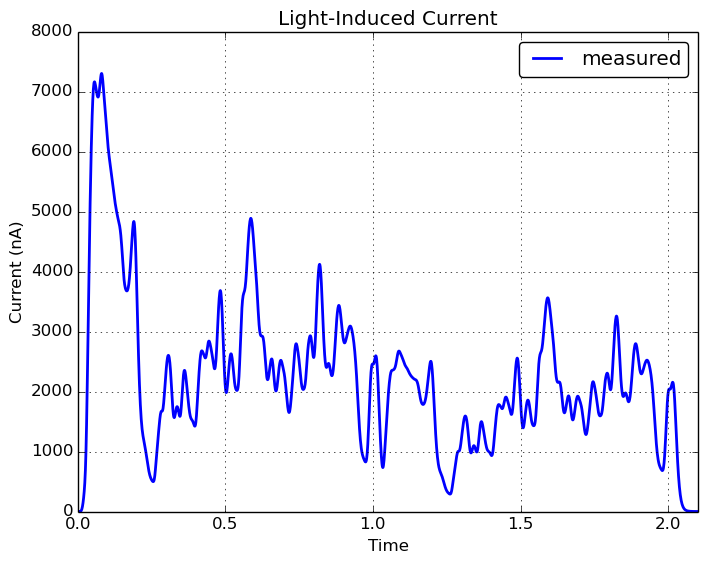

PyObject <matplotlib.legend.Legend object at 0x7fe6e3463610>

In [21]:
###Plot the measurement data (simmulated data + noise)
figure("PhotoReceptor1") ; clf()
plot(dataindex(model1),measurements(model1);label="measured",linewidth=2)
xlabel("Time")
ylabel("Current (nA)")
xlim(dataindex(model1)[1],dataindex(model1)[end])
title("Light-Induced Current")
grid("on")
legend(loc="upper right",fancybox="true")

In [22]:
###Create a Metropolis sampler with a Normal proposal density
propcov = [0.1,0.01,0.1,0.01,0.1,0.01,0.01]
sampler1 = sampler(:mh,:normal,1.0,propcov)
println("============================")
println("Sampler defined successfully")
println("============================")
show(sampler1)
println(" initialscalefactor: $(sampler1.initialscalefactor)")
println(" covariance: $(sampler1.covariance)")
println()

###Create a tuner, either one that scales the stepsize of the proposal density or one that monitors acceptance rates
#tuner1 = tuner(:scale,ntunerperiod,0.5,:erf)
tuner1 = tuner(:monitor,ntunerperiod)
println("==========================")
println("Tuner defined successfully")
println("==========================")
show(tuner1)

###Create a Generalized Metropolis-Hastings runner (which will default to Standard MH when nproposals=1)
runnerpolicy1 = policy(:gmh,nproposals;initialize=:prior)
runner1 = runner(:gmh,niterations,nproposals,runnerpolicy1;numburnin = nburnin)
println("===========================")
println("Runner defined successfully")
println("===========================")
show(runner1)

Sampler defined successfully
AbstractSampler MHNormal with fields:
  [:initialscalefactor,:covariance]
 initialscalefactor: 1.0
 covariance: [0.1,0.01,0.1,0.01,0.1,0.01,0.01]

Tuner defined successfully
MonitorTuner: period = 5, verbose = true
Runner defined successfully
Generalized Metropolis-Hastings runner with:
 numiterations: 100
 numproposals: 10000
 numindicatorsamples: 10000
 numtotalsamples: 1000000
 numburnin: 0
 policy: GMHPolicy with traits:
  initialize = prior
  propose = auxiliary
  indicator = stationary
  samplerstates = nworkers
  sampletype = Float64
  calculationtype = Float64




In [23]:
###Run the MCMC (can take quite a bit of time)
println("=======================")
println("Run the MCMC simulation")
println("=======================")
chain1 = run!(runner1,model1,sampler1,tuner1)
println("=========================")
println("Completed MCMC simulation")
println("=========================")

Run the MCMC simulation


Iteration 5/100
Iteration 10/100
Iteration 15/100
Iteration 20/100


Iteration 25/100


Iteration 30/100


Iteration 35/100


Iteration 40/100


Iteration 45/100


Iteration 50/100


Iteration 55/100


Iteration 60/100


Iteration 65/100


Iteration 70/100


Iteration 75/100


Iteration 80/100


Iteration 85/100


Iteration 90/100


Iteration 95/100


Iteration 100/100
Completed MCMC simulation


In [24]:
###Show the result of the simulations
show(chain1)
nparas = numparas(model1)
meanparamvals = mean(samples(chain1),2)
stdparamvals = std(samples(chain1),2)

println("Results of the MCMC simulation:")
for i=1:nparas
    println("mean $(parameters(model1)[i].key): $(meanparamvals[i])")
    println("std $(parameters(model1)[i].key): $(stdparamvals[i])")
end

ChainStandard with numparas = 7 and numsamples = 1000000
Samples proposed = 1000000, samples accepted = 194, acceptance rate = 0.000194
Total runtime = 1142.199846662
Additional fields: :values, :loglikelihood
Results of the MCMC simulation:
mean latencylocation: 2.5389146832083616
std latencylocation: 0.07754674746288581
mean latencyscale: 0.4245125317280577
std latencyscale: 0.01480324233683274
mean refractorylocation: 4.8888420062619815
std refractorylocation: 0.0480958177019549
mean refractoryscale: 2.08807744520362
std refractoryscale: 0.06831273372752826
mean bumpamplitude: 3.156033115888943
std bumpamplitude: 0.29249399904659384
mean bumpshape: 2.786237112257502
std bumpshape: 0.1458962055045983
mean bumpscale: 3.2978335607655023
std bumpscale: 0.19870367248809678


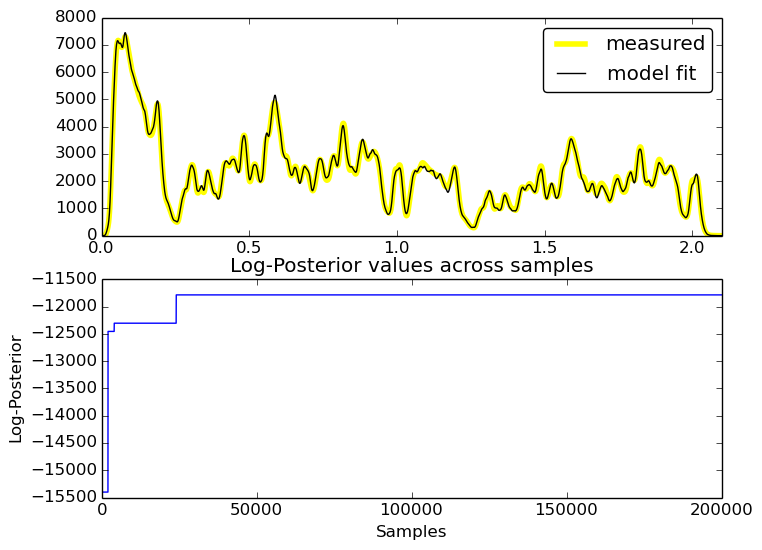

PyObject <matplotlib.text.Text object at 0x7fe6e33ae750>

Plotting results


In [17]:
println("================")
println("Plotting results")
println("================")

###Plot the average model results in the data window
subplot(211)
modeldata = evaluate!(model1,vec(meanparamvals))
plot(dataindex(model1),measurements(model1);label="measured",linewidth=4,color="yellow")
plot(dataindex(model1),modeldata;label="model fit",linewidth=1,color="black")
xlim(dataindex(model1)[1],dataindex(model1)[end])
legend(loc="upper right",fancybox="true")

###Plot the logposterior values across samples
subplot(212)
plot(1:numsamples(chain1),logposterior(chain1,model1))
title("Log-Posterior values across samples")
xlabel("Samples")
ylabel("Log-Posterior")



In [ ]:
###Plot the histograms of parameter values
for i=1:4
    subplot(220 + i)
    bins = meanparamvals[i]-0.2:0.01:meanparamvals[i]+0.2
    h = PyPlot.plt[:hist](sub(samples(chain1),i,:)',bins)
    grid("on")
    title("$(parameters(model1)[i].key)")
    if i > 2
        xlabel("Values")
    end
    if i == 1 || i == 3
        ylabel("Samples")
    end
    xlim(meanparamvals[i]-0.2,meanparamvals[i]+0.2)
end

In [ ]:
###Only run this box if you want to shut down all worker processes
println("Pre processes running: ",procs())
for i in workers()
    if i != 1
        rmprocs(i)
    end
end
println("Post processes running: ",procs())